# Imports

In [547]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from networkx.classes.reportviews import NodeView, EdgeView, OutEdgeView
from random_graph import RandomGraphBuilder
from typing import Mapping, Union

# Girvan-Newman Algorithm

In [548]:
import networkx as nx

def girvan_newman_animated(G: nx.Graph | nx.DiGraph) -> nx.Graph | nx.DiGraph:
    """
    Implementation of the Girvan-Newman algorithm for detecting communities in a graph
    by iteratively removing edges from the original graph. 
    :param G: The input networkx Graph or DiGraph object
    :return: A graph with a singular contracted node and zero edges
    """
    # Set up list of animation frames to record the steps
    animation_steps = []

    components = list(nx.connected_components(G))
    while len(components) == 1:
        # Get the dictionary of edges to betweenness values using networkx
        btwnss = nx.edge_betweenness_centrality(G)
        # Store the highest betweenness value 
        max_btwnss = max(btwnss.values())

        # Remove the edge(s) from the graph
        for key, value in btwnss.items():
            if value == max_btwnss:
                G.remove_edge(*key)

                animation_steps.append((set(G.edges), btwnss))

        # Check the connected components after edge removal
        components = list(nx.connected_components(G))
    # and stop removing edges when the number of connected components increases
    return tuple(components), animation_steps

# Animation and Visualization

### `update_anim` function
This function is called to update the plot for each frame.

In [549]:
def update_anim(frame: tuple[set[NodeView], set[Union[EdgeView, OutEdgeView]], Mapping], communities, pos, ax):
    ax.clear()

    # Extract current state from frame
    edges, betweenness_dict = frame

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink', 'brown', 'cyan', 'magenta']
    for i, community in enumerate(communities):
        G = nx.Graph()
        G.add_nodes_from(community)
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors[i])
        nx.draw_networkx_labels(G, pos, ax=ax, font_color='lightgrey')

        # Round off all the values in the betweenness dictionary
        # And remove edges that aren't in `edges`
        edge_labels = {edge: round(btwnss, 2) for edge, btwnss in betweenness_dict.items() if edge in edges}
        G = nx.Graph()
        # Don't add edges that were drawn in the previous community
        previous_communities = []
        for t in range(i):
            previous_communities.extend(communities[t])
        G.add_edges_from([edge for edge in edge_labels.keys() if edge[0] not in previous_communities and edge[1] not in previous_communities])
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color=colors[i])
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_color='grey')

### Graph Generation

#### Determine graph variables

In [550]:
num_nodes = random.randint(5, 12)
max_edges = (num_nodes * (num_nodes - 1)) / 2
exp_edges = random.randint(num_nodes - 1, max_edges)
edge_density = exp_edges / max_edges

#### Build a Graph object

In [551]:
G1 = RandomGraphBuilder() \
    .nodes(num_nodes) \
    .random_edges(edge_density) \
    .weighted(range(1,10)) \
    .complete() \
    .build()

G2 = RandomGraphBuilder() \
    .nodes(num_nodes) \
    .random_edges(edge_density) \
    .weighted(range(1,10)) \
    .complete() \
    .build()

In [552]:
G = nx.disjoint_union(G1, G2)
# Remove some random edges
for i in range(random.randint(1, 6)):
    G.remove_edge(*random.choice(list(G.edges)))
# Insert random edges between the two graphs
for i in range(num_nodes):
    G.add_edge(i, i + num_nodes, weight=random.randint(1, 10))

#### Plot the initial Graph

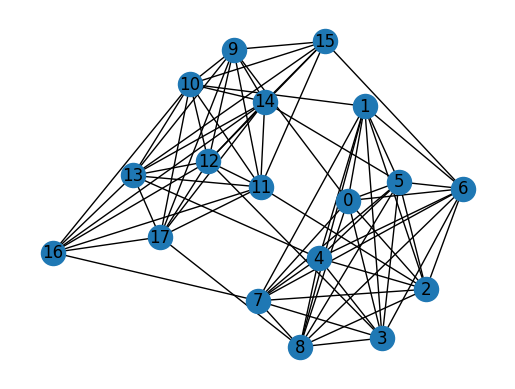

In [553]:
pos = nx.spring_layout(G)
fig, ax = plt.subplots()
nx.draw(G, pos, ax=ax, with_labels=True)

## Run the algorithm

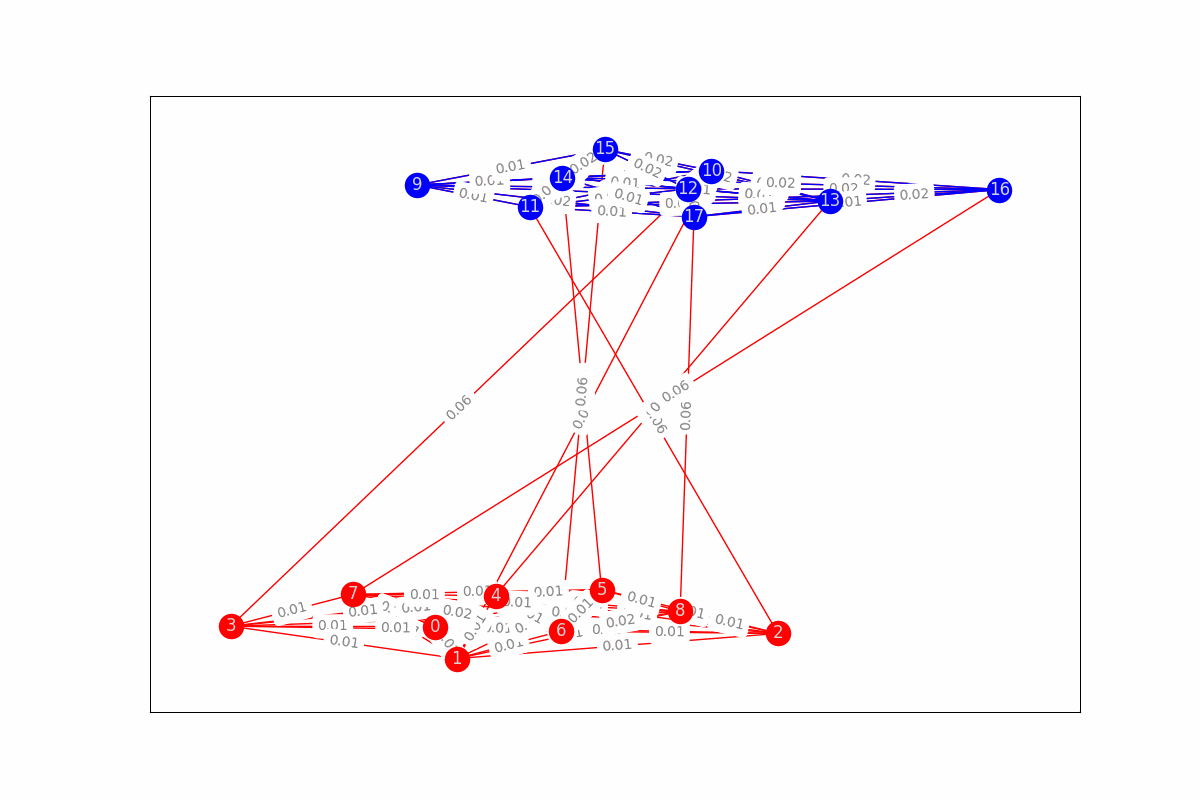

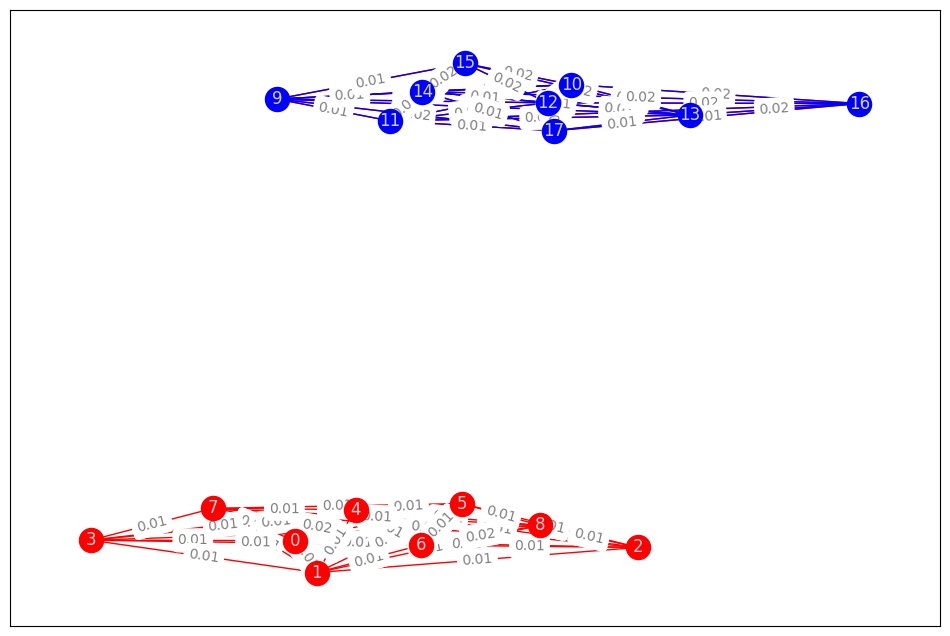

In [554]:
# Run the Girvan-Newman algorithm with animation step tracking
communities, animation_steps = girvan_newman_animated(G)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G)  # Use shell_layout to avoid nodes on top of edges

# Finally, create the animation
FuncAnimation(fig, update_anim, frames=animation_steps, fargs=(communities, pos, ax), interval=1000, repeat=False).save("girvan_newman_animation.gif", writer='pillow', fps=0.5)

# And display the animation in a way that jupyter supports
Image(filename="girvan_newman_animation.gif")